## 1. Problem Statement

The goal of this project is to build a deep learning RNN model that predicts which Tweets are about real disasters and which ones are not. We are provided with a dataset of 10,000 hand-labeled tweets, split into training and test sets.

### Data Description

- **train.csv**: Contains tweets with labels (`target`: 1 for disaster, 0 for not).
- **test.csv**: Contains tweets without labels (to predict).
- **Columns**:
    - `id`: Unique identifier for each tweet
    - `keyword`: A keyword from the tweet (may be missing)
    - `location`: The location the tweet was sent from (may be missing)
    - `text`: The text of the tweet
    - `target`: (train only) 1 if the tweet is about a real disaster, 0 otherwise

## 2. EDA

### 2.1 Basic EDA

In [94]:
import pandas as pd
import matplotlib.pyplot as plt


# Load data
print("Loading dataset...")
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
print(f"Dataset loaded successfully! Shape: {train.shape}")

# Basic info
print("DATA INSPECTION")
print("\n1. First 10 rows:")
display(train.head())

print("\n2. Data Info:")
print(train.info())


print("\n3. Target Value Counts:")
print(train['target'].value_counts())


print("\n4. Missing Value Counts:")
print(train.isnull().sum())



Loading dataset...
Dataset loaded successfully! Shape: (7613, 5)
DATA INSPECTION

1. First 10 rows:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



2. Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

3. Target Value Counts:
target
0    4342
1    3271
Name: count, dtype: int64

4. Missing Value Counts:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### 2.2 Detailed EDA

target analysis


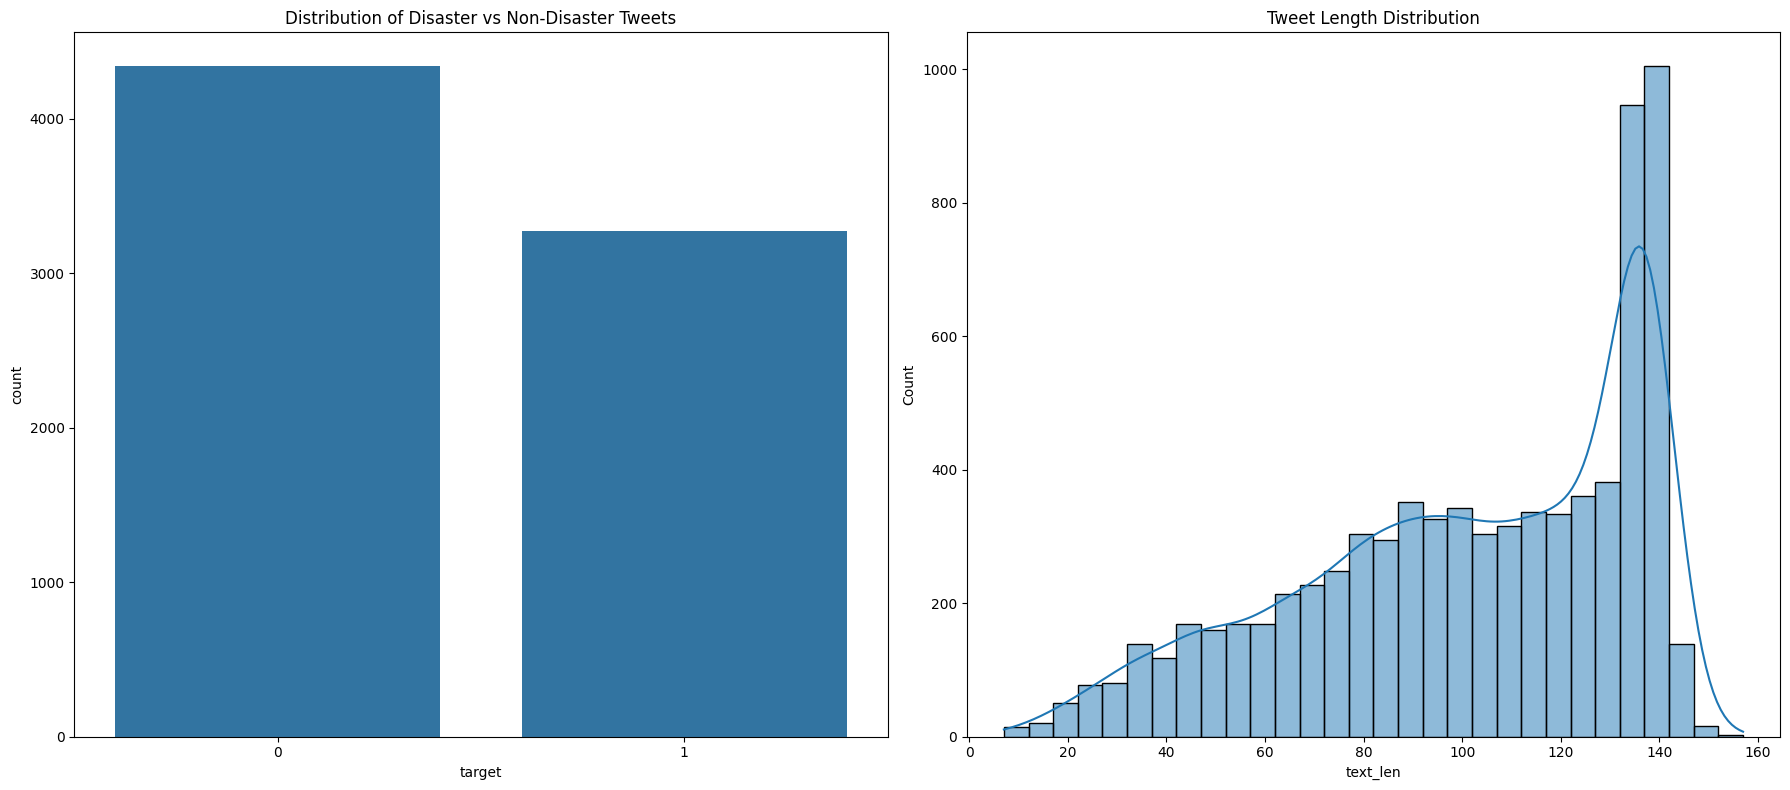

keyword analysis


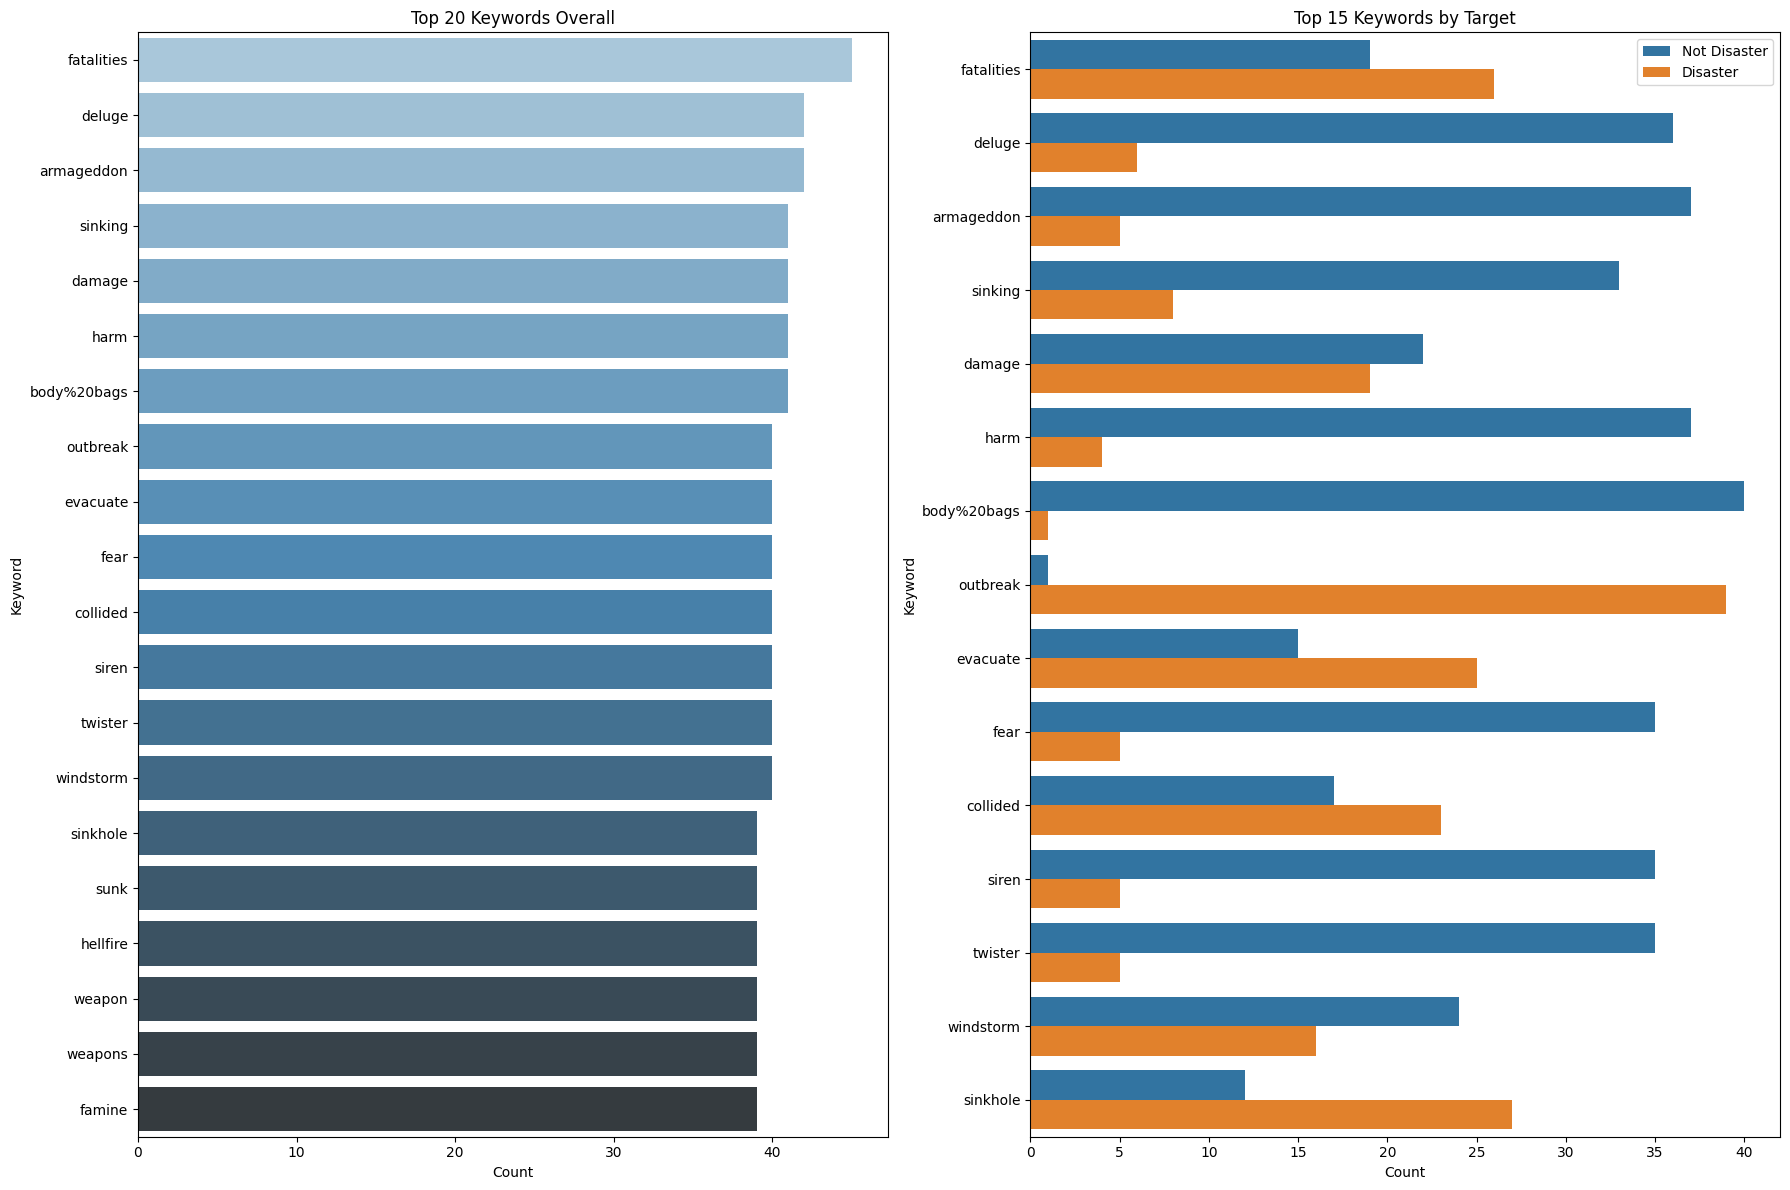

Tweet Length by Label - To check if disaster tweets longer or shorter than non-disaster tweets?


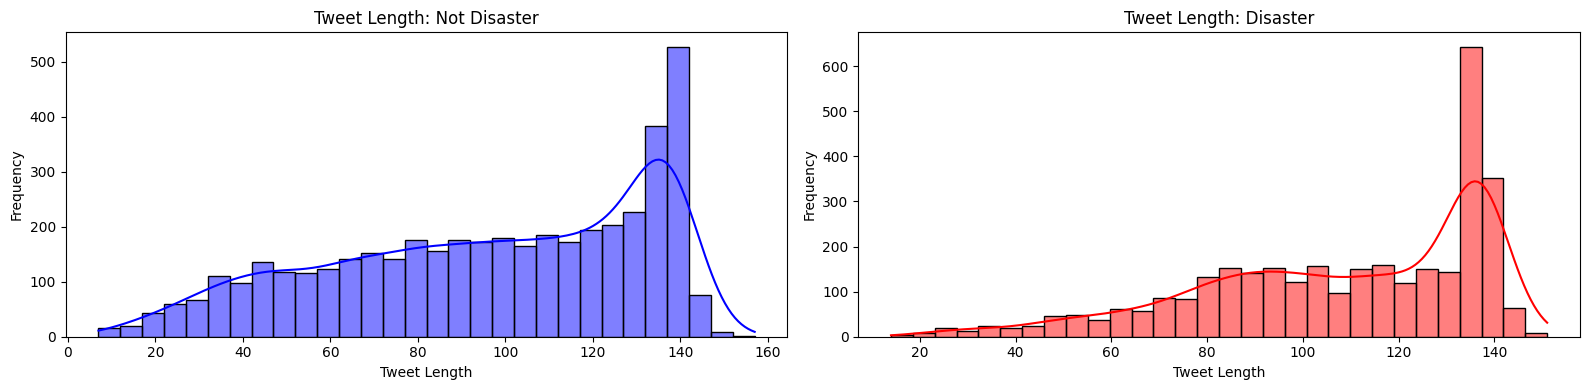

How many tweets that are marked disaster have keywords?


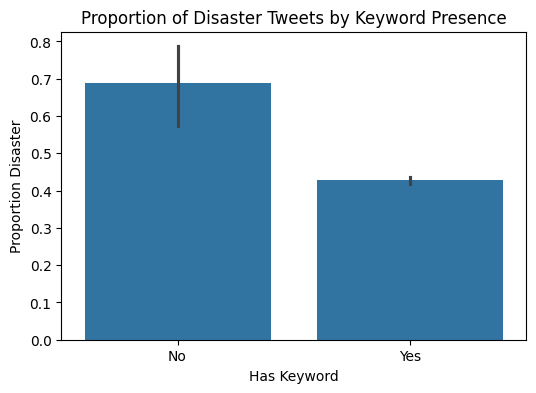

Side by side word clouds for disaster and non-disaster tweets


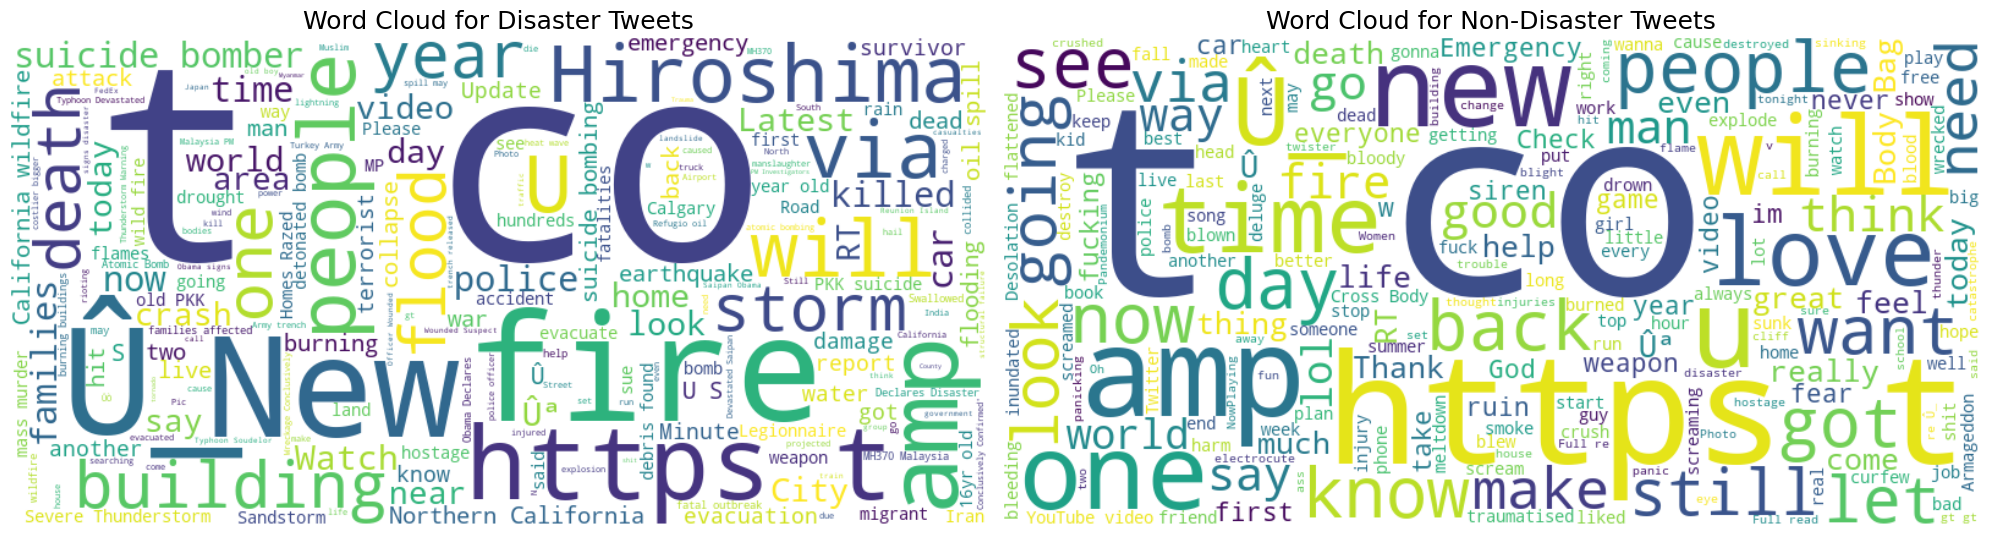

In [95]:
# Visualize class distribution
import seaborn as sns
from wordcloud import WordCloud

print("target analysis")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(x='target', data=train, ax=axes[0])
axes[0].set_title('Distribution of Disaster vs Non-Disaster Tweets')

# Tweet length distribution
train['text_len'] = train['text'].apply(len)
sns.histplot(train['text_len'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Tweet Length Distribution')

plt.tight_layout()
plt.show()


# Side-by-side charts for keyword analysis
print("keyword analysis")
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# Top 20 keywords overall
top_keywords = train['keyword'].value_counts().head(20)
sns.barplot(x=top_keywords.values, y=top_keywords.index, ax=axes[0], hue=top_keywords.index, palette="Blues_d", legend=False)
axes[0].set_title('Top 20 Keywords Overall')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Keyword')

# Top 15 keywords by target
top15_keywords = train['keyword'].value_counts().head(15).index
sns.countplot(data=train, y='keyword', hue='target', order=top15_keywords, ax=axes[1])
axes[1].set_title('Top 15 Keywords by Target')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Keyword')
axes[1].legend(['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

print('Tweet Length by Label - To check if disaster tweets longer or shorter than non-disaster tweets?')
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot for Not Disaster
sns.histplot(
    data=train[train['target'] == 0],
    x='text_len',
    bins=30,
    kde=True,
    color='blue',
    ax=axes[0]
)
axes[0].set_title('Tweet Length: Not Disaster')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')

# Plot for Disaster

sns.histplot(
    data=train[train['target'] == 1],
    x='text_len',
    bins=30,
    kde=True,
    color='red',
    ax=axes[1]
)
axes[1].set_title('Tweet Length: Disaster')
axes[1].set_xlabel('Tweet Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print('How many tweets that are marked disaster have keywords?')
plt.figure(figsize=(6,4))
sns.barplot(x=train['keyword'].notnull(), y=train['target'])
plt.title('Proportion of Disaster Tweets by Keyword Presence')
plt.xlabel('Has Keyword')
plt.ylabel('Proportion Disaster')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()


print("Side by side word clouds for disaster and non-disaster tweets")
disaster_text = ' '.join(train[train['target']==1]['text'])
nondisaster_text = ' '.join(train[train['target']==0]['text'])

wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
wordcloud_nondisaster = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_text)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(wordcloud_disaster, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud for Disaster Tweets', fontsize=18)

axes[1].imshow(wordcloud_nondisaster, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud for Non-Disaster Tweets', fontsize=18)

plt.tight_layout()
plt.show()

### 2.3 Data Cleaning & Feature Engineering

- As we can see from our EDA there are some unwanted words that are present like https, # etc. We will go a head and clean that data.
- We see that we have a some null values in keyword columns. We marke them as `'<NO_KEYWORD>'`. The model can discover on its own whether “no keyword” correlates with disaster or non-disaster tweets
- `Location` in this dataset is notoriously noisy (country, lat-long, city etc) and sparsely populated (many nulls), and in practice it often adds more noise than signal. So I am choosing to create a new feature `has_location` which is simply a boolean.
- We add some Tweet-level engineered features to see if they can help make better model, e.g.:

    - text_length = len(text)

    - num_hashtags = text.count('#')

    - num_mentions = text.count('@')

    - uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text)

In [96]:
import re

# Clean text function (implement as needed)
def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub(r'<.*?>', '', text) # remove HTML tags
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # remove extra whitespace
    return text

train['clean_text'] = train['text'].apply(clean_text)

# Fill missing values in 'keyword' with a placeholder
train['keyword'] = train['keyword'].fillna('<NO_KEYWORD>')

#Add new feature for location indicator
train['has_location'] = train['location'].notna().astype(int)
test ['has_location'] = test ['location'].notna().astype(int)

#dropping text location as we dont need it
train = train.drop(columns=['location'])
test  = test.drop(columns=['location'])


# 2) Add simple text-based features
for df in (train, test):
    df['text_len']      = df['text'].str.len()
    df['num_hashtags']  = df['text'].str.count('#')
    df['num_mentions']  = df['text'].str.count('@')
    df['upper_ratio']   = df['text'].apply(lambda t: sum(c.isupper() for c in t) / max(1,len(t)))


display(train.head())
print(train.info())
print(train['target'].value_counts())


,id,keyword,text,target,text_len,clean_text,has_location,num_hashtags,num_mentions,upper_ratio
0,1,<NO_KEYWORD>,Our Deeds are the Reason of this #earthquake M...,1,69,our deeds are the reason of this may allah for...,0,1,0,0.144928
1,4,<NO_KEYWORD>,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,0,0,0,0.131579
2,5,<NO_KEYWORD>,All residents asked to 'shelter in place' are ...,1,133,all residents asked to shelter in place are be...,0,0,0,0.015038
3,6,<NO_KEYWORD>,"13,000 people receive #wildfires evacuation or...",1,65,people receive evacuation orders in california,0,1,0,0.015385
4,7,<NO_KEYWORD>,Just got sent this photo from Ruby #Alaska as ...,1,88,just got sent this photo from ruby as smoke fr...,0,2,0,0.034091


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            7613 non-null   int64  
 1   keyword       7613 non-null   object 
 2   text          7613 non-null   object 
 3   target        7613 non-null   int64  
 4   text_len      7613 non-null   int64  
 5   clean_text    7613 non-null   object 
 6   has_location  7613 non-null   int64  
 7   num_hashtags  7613 non-null   int64  
 8   num_mentions  7613 non-null   int64  
 9   upper_ratio   7613 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 594.9+ KB
None
target
0    4342
1    3271
Name: count, dtype: int64


## 3.RNN Model

We will use a Sequential RNN model with LSTM and GRU architectures and compare their performance.

### 3.1 Model Architecture

1. **Tokenization & Embedding**  
   - Convert each tweet into a sequence of integer indices via Keras’s `Tokenizer`.  
   - Map indices into a **trainable** embedding space (`Embedding(vocab_size, embed_dim)`), so the model learns task-specific word relationships.

2. **Bidirectional LSTM Stack**  
   - `Bidirectional()` with two layers of `LSTM` and `GRU` for two different models respectively (Presented for comparison).  
   - Allows the network to read the tweet both forwards and backwards, capturing context from both ends.  
   - LSTMs handle longer-range dependencies than simple RNNs, helping with varied tweet lengths.

3. **Regularization**  
   - `SpatialDropout1D(0.3)` zeroes out entire embedding channels.  
   - Each LSTM uses both `dropout` and `recurrent_dropout` to prevent over-fitting.

4. **Metadata Fusion**  
   - Engineered five features:  
     - `has_location` (0/1)  
     - `text_len` (tweet length)  
     - `num_hashtags`  
     - `num_mentions`  
     - `upper_ratio` (uppercase proportion)  
   - Concatenated to the final GRU output before the dense layer.

5. **Dense & Output Layers**  
   - A 64-unit `Dense` layer with L₂ regularization + dropout.  
   - Final sigmoid output for binary classification.

6. **Training Parameters**  
   - Class weights to rebalance labels.  
   - Early stopping on validation loss.  
   - Adam (or AdamW) optimizer with gradient clipping or weight decay.

### 3.2 Text to matrix - Tokenization 

RNNs can’t work on raw strings, so we need to turn each tweet text into a sequence of numbers like `[12, 534, 7, …]`. For this , we took raw text and created an integer sequences (via Keras’s `Tokenizer`) for a trainable Embedding laye for our RNN model. Here is how it works:
 
 - Scans our tweets `clean_text` and builds a vocabulary of the top V most frequent words, and assigns each a unique index (1…V) 
 RNNs can’t work on raw strings, so we need to turn each tweet into a sequence of numbers like [12, 534, 7, …]

In [69]:
#hyper-parameters

VOCAB_SIZE = 10000
EMBED_DIM  = 128
MAXLEN     = 150
BATCH_SIZE = 64
EPOCHS     = 20
SEED       = 42

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Tokenization and Padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<NO_KEYWORD>')
tokenizer.fit_on_texts(train ['clean_text'])
X_sequences = tokenizer.texts_to_sequences(train ['clean_text'])
X_padded = pad_sequences(X_sequences, maxlen=MAXLEN, padding='post', truncating='post')
y = train['target'].values


# meta features matrix
meta_cols = ['has_location','text_len','num_hashtags','num_mentions','upper_ratio']
X_meta = train[meta_cols].values


# Train/val split
X_train_txt, X_val_txt, X_train_meta, X_val_meta, y_train, y_val = train_test_split(
    X_padded, X_meta, y, test_size=0.2, random_state=SEED, stratify=y
)


#class weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: cw[i] for i in range(len(cw))}

### 3.3 RNN LSTM Model building and training

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

#RNN LSTM Model building and training

#Text input (sequence of token IDs)
txt_in = Input(shape=(MAXLEN,), name='text_input')

# Meta input (e.g. has_location, text_len, num_hashtags, num_mentions, upper_ratio)
meta_in = Input(shape=(5,), name='meta_input')

#Text pipeline with Bidirectional LSTM
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAXLEN)(txt_in)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.5)(x)

# Concatenate the RNN output with your meta-features
combined = Concatenate()([x, meta_in])

#Final dense layers
z = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
out = Dense(1, activation='sigmoid')(z)

#  f) Build the model
model_lstm = Model(inputs=[txt_in, meta_in], outputs=out)

#Compline and Summary
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

#Model Training
history_lstm = model_lstm.fit(
    x={'text_input': X_train_txt, 'meta_input': X_train_meta},
    y=y_train,
    validation_data=(
      {'text_input': X_val_txt,   'meta_input': X_val_meta},
      y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/Disaster_Tweets/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 100, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 100, 128)  │     98,816 │ embedding_12[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 100, 128)  │          0 │ bidirectional_24… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (None, 64)        │     41,216 │ dropout_32[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64)        │          0 │ bidirectional_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 69)        │          0 │ dropout_33[0][0], │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      4,480 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1)         │         65 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,424,577 (5.43 MB)

 Trainable params: 1,424,577 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 432ms/step - accuracy: 0.5249 - loss: 2.1034 - val_accuracy: 0.5640 - val_loss: 0.7095
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 405ms/step - accuracy: 0.5727 - loss: 0.7132 - val_accuracy: 0.7183 - val_loss: 0.5992
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 356ms/step - accuracy: 0.7944 - loss: 0.5093 - val_accuracy: 0.7577 - val_loss: 0.5618
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.8758 - loss: 0.3620 - val_accuracy: 0.7479 - val_loss: 0.6258
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step - accuracy: 0.9196 - loss: 0.2688 - val_accuracy: 0.7393 - val_loss: 0.7418
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - accuracy: 0.9364 - loss: 0.2429 - val_accuracy: 0.7623 - val_loss: 0.7883


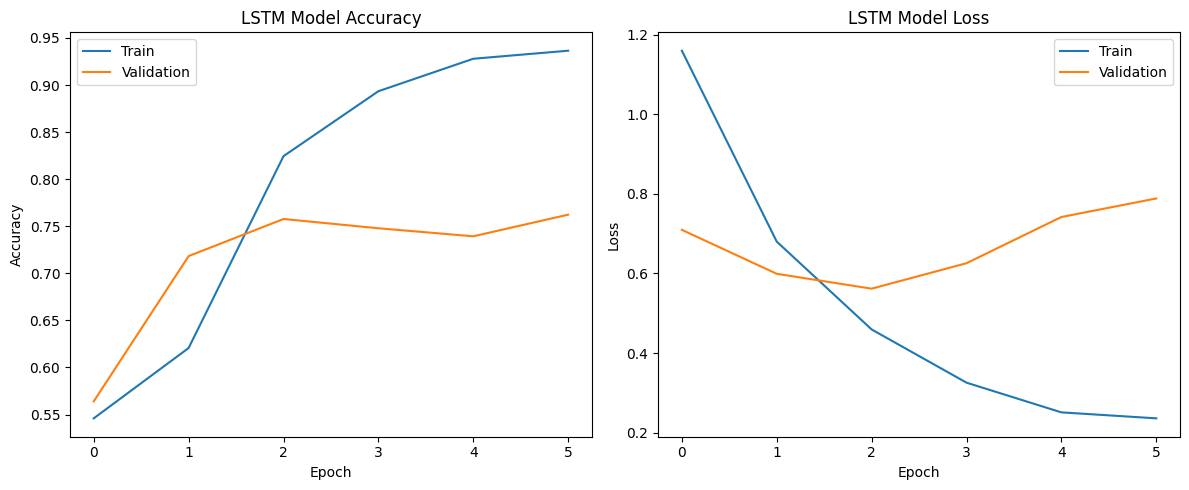

In [76]:
# Plot training history: accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history_lstm.history['accuracy'], label='Train')
axs[0].plot(history_lstm.history['val_accuracy'], label='Validation')
axs[0].set_title('LSTM Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss plot
axs[1].plot(history_lstm.history['loss'], label='Train')
axs[1].plot(history_lstm.history['val_loss'], label='Validation')
axs[1].set_title('LSTM Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Analysis

- Convergen point is achived at 3rd epoch.
- LSTM model shows high accuracy score on validation train but low in valiation. This is due to overfitting 
- Train accuracy is 93% but validation is only 70-75% model is reasonably good for baseline but needs more tuning

### LSTM Hyperparameter Tuning 

In [79]:
import numpy as np

param_grid = [
    {'lstm_units': 32, 'dropout': 0.3, 'dense_units': 32, 'l2_reg': 0.001},
    {'lstm_units': 64, 'dropout': 0.5, 'dense_units': 64, 'l2_reg': 0.001},
    {'lstm_units': 128, 'dropout': 0.5, 'dense_units': 64, 'l2_reg': 0.0005},
    # Add more combinations as needed
]

results = []

for i, params in enumerate(param_grid):
    print(f"Training model {i+1} with params: {params}")
    # Model definition
    txt_in = Input(shape=(MAXLEN,), name='text_input')
    meta_in = Input(shape=(5,), name='meta_input')
    x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAXLEN)(txt_in)
    x = Bidirectional(LSTM(params['lstm_units'], return_sequences=True))(x)
    x = Dropout(params['dropout'])(x)
    x = Bidirectional(LSTM(params['lstm_units']//2))(x)
    x = Dropout(params['dropout'])(x)
    combined = Concatenate()([x, meta_in])
    z = Dense(params['dense_units'], activation='relu', kernel_regularizer=l2(params['l2_reg']))(combined)
    out = Dense(1, activation='sigmoid')(z)
    model = Model(inputs=[txt_in, meta_in], outputs=out)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    # Training
    history = model.fit(
        x={'text_input': X_train_txt, 'meta_input': X_train_meta},
        y=y_train,
        validation_data=(
            {'text_input': X_val_txt, 'meta_input': X_val_meta},
            y_val
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )
    # Record results
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    results.append({
        'params': params,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'history': history.history
    })
    print(f"----------Training Complete----------")
    print(f"Best val_acc: {best_val_acc:.4f} at epoch {best_epoch}")



Training model 1 with params: {'lstm_units': 32, 'dropout': 0.3, 'dense_units': 32, 'l2_reg': 0.001}


/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/Disaster_Tweets/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


----------Training Complete----------
Best val_acc: 0.7919 at epoch 5
Training model 2 with params: {'lstm_units': 64, 'dropout': 0.5, 'dense_units': 64, 'l2_reg': 0.001}
----------Training Complete----------
Best val_acc: 0.7544 at epoch 4
Training model 3 with params: {'lstm_units': 128, 'dropout': 0.5, 'dense_units': 64, 'l2_reg': 0.0005}
----------Training Complete----------
Best val_acc: 0.7702 at epoch 2


,params,best_val_acc,best_epoch,history
0,"{'lstm_units': 32, 'dropout': 0.3, 'dense_unit...",0.791858,5,"{'accuracy': [0.5264368057250977, 0.5663382411..."
1,"{'lstm_units': 64, 'dropout': 0.5, 'dense_unit...",0.754432,4,"{'accuracy': [0.6062397360801697, 0.8246305584..."
2,"{'lstm_units': 128, 'dropout': 0.5, 'dense_uni...",0.770190,2,"{'accuracy': [0.5594416856765747, 0.7599343061..."


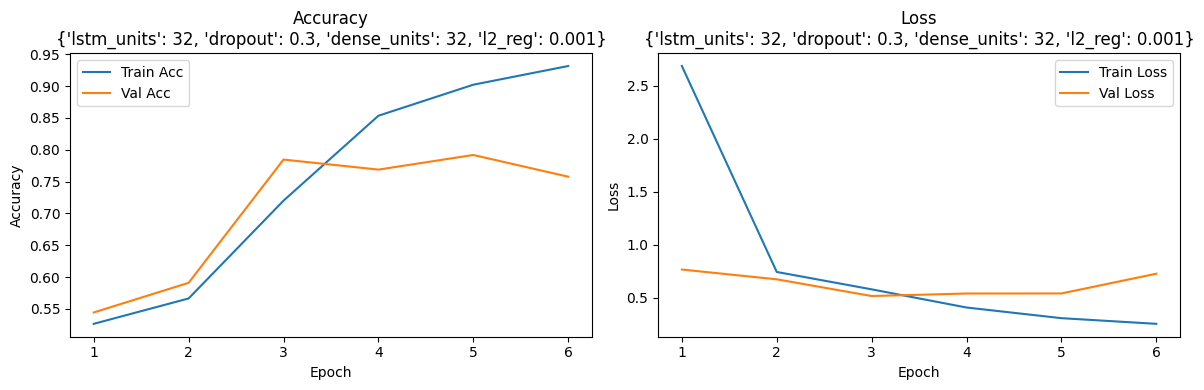

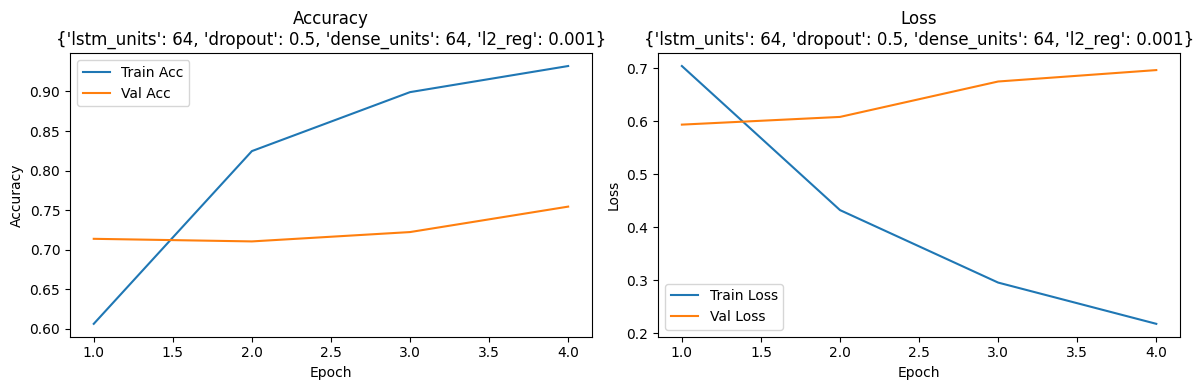

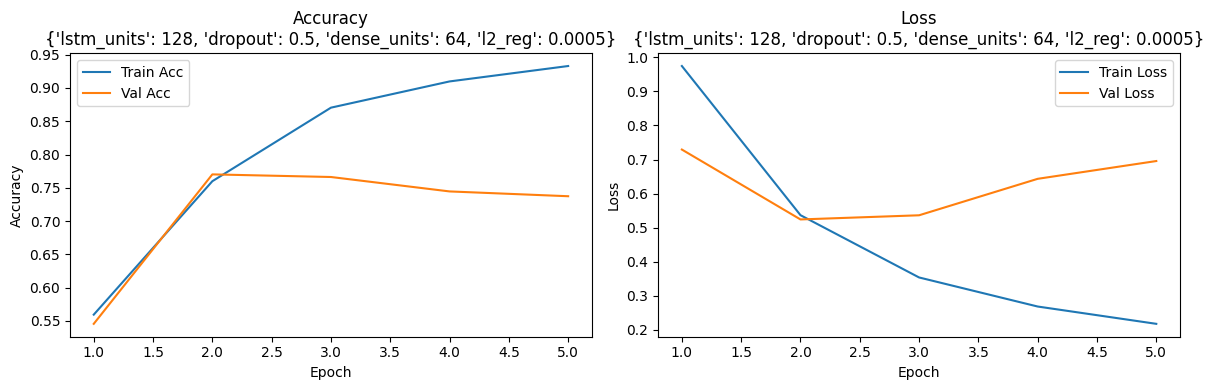

In [80]:
# Show results as a DataFrame
results_df = pd.DataFrame(results)
display(results_df)


for i, result in enumerate(results):
    hist = result['history']
    params_str = str(result['params'])
    epochs = range(1, len(hist['accuracy']) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    axs[0].plot(epochs, hist['accuracy'], label='Train Acc')
    axs[0].plot(epochs, hist['val_accuracy'], label='Val Acc')
    axs[0].set_title(f'Accuracy\n{params_str}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    # Loss plot
    axs[1].plot(epochs, hist['loss'], label='Train Loss')
    axs[1].plot(epochs, hist['val_loss'], label='Val Loss')
    axs[1].set_title(f'Loss\n{params_str}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

What worked and what didnt? 

- Our extra text features extracted from tweet did not add any significant value to prediction. Because I saw results of baseline models on kaggle they have approx same accuracy.

- Hypeparameter tuning:
    - Very Large LSTM Layers: Increasing LSTM units beyond a certain point (e.g., 128+) led to overfitting and did not improve validation accuracy. Low 32 layers gave best result.
    - Low Dropout Rates: Using little or no dropout resulted in rapid overfitting, with training accuracy much higher than validation accuracy.

#### LSTM with optimized hyper parameters

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

#RNN LSTM Model building and training with 32 optimized  hyperparameters

#Text input (sequence of token IDs)
txt_in = Input(shape=(MAXLEN,), name='text_input')

# Meta input (e.g. has_location, text_len, num_hashtags, num_mentions, upper_ratio)
meta_in = Input(shape=(5,), name='meta_input')

#Text pipeline with Bidirectional LSTM
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAXLEN)(txt_in)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.3)(x)

# Concatenate the RNN output with your meta-features
combined = Concatenate()([x, meta_in])

#Final dense layers
z = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
out = Dense(1, activation='sigmoid')(z)

#  f) Build the model
model_lstm = Model(inputs=[txt_in, meta_in], outputs=out)

#Compline and Summary
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

#Model Training
history_lstm = model_lstm.fit(
    x={'text_input': X_train_txt, 'meta_input': X_train_meta},
    y=y_train,
    validation_data=(
      {'text_input': X_val_txt,   'meta_input': X_val_meta},
      y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/Disaster_Tweets/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 100, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_38    │ (None, 100, 64)   │     41,216 │ embedding_19[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 100, 64)   │          0 │ bidirectional_38… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_39    │ (None, 64)        │     24,832 │ dropout_46[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 64)        │          0 │ bidirectional_39… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 69)        │          0 │ dropout_47[0][0], │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 64)        │      4,480 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 1)         │         65 │ dense_54[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,350,593 (5.15 MB)

 Trainable params: 1,350,593 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.4857 - loss: 2.8163 - val_accuracy: 0.6343 - val_loss: 0.6987
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step - accuracy: 0.6864 - loss: 0.6295 - val_accuracy: 0.7774 - val_loss: 0.5244
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.8493 - loss: 0.4055 - val_accuracy: 0.7630 - val_loss: 0.5854
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.9092 - loss: 0.2777 - val_accuracy: 0.7236 - val_loss: 0.7429
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step - accuracy: 0.9338 - loss: 0.2130 - val_accuracy: 0.7557 - val_loss: 0.7387


Best val_acc: 0.7702 at epoch 2


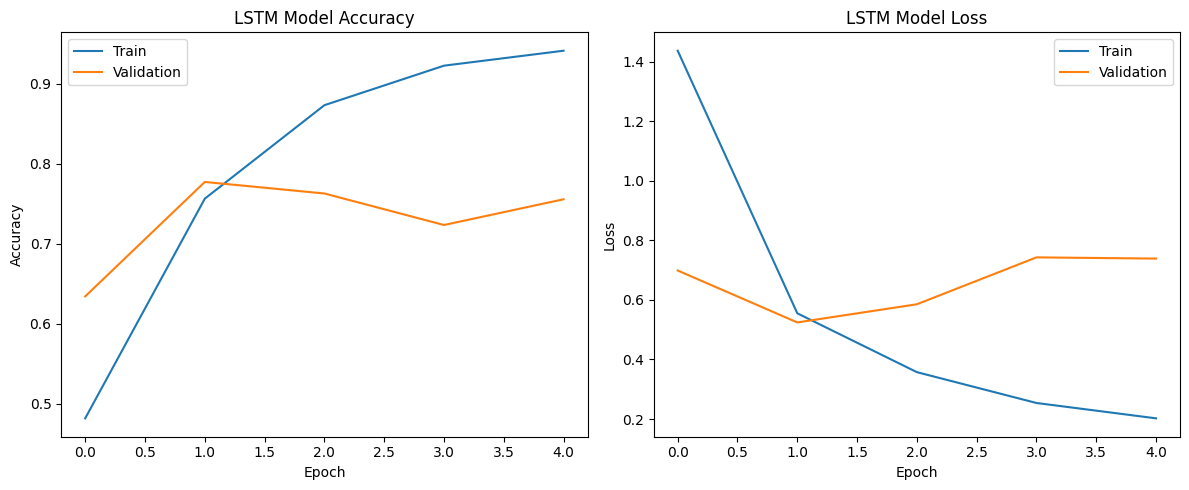

In [83]:
 # Record results
best_val_acc = max(history.history['val_accuracy'])
best_epoch = np.argmax(history.history['val_accuracy']) + 1
results.append({
    'params': params,
    'best_val_acc': best_val_acc,
    'best_epoch': best_epoch,
    'history': history.history
})

print(f"Best val_acc: {best_val_acc:.4f} at epoch {best_epoch}")

# Plot training history: accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history_lstm.history['accuracy'], label='Train')
axs[0].plot(history_lstm.history['val_accuracy'], label='Validation')
axs[0].set_title('LSTM Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss plot
axs[1].plot(history_lstm.history['loss'], label='Train')
axs[1].plot(history_lstm.history['val_loss'], label='Validation')
axs[1].set_title('LSTM Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### 3.4 Bidirectional RNN GRU

In this model we will skip adding extra meta features and also use `ReduceLROnPlateau` callback. And instead of using standard dropout layer we use `SpatialDropout1D` Layer. 

/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/Disaster_Tweets/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 100, 128)       │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ (None, 64)             │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,389,825 (5.30 MB)

 Trainable params: 1,389,825 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
96/96 - 104s - 1s/step - accuracy: 0.6575 - loss: 0.6526 - val_accuracy: 0.7676 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 2/20
96/96 - 57s - 598ms/step - accuracy: 0.8361 - loss: 0.4247 - val_accuracy: 0.7623 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 3/20
96/96 - 58s - 608ms/step - accuracy: 0.8875 - loss: 0.3120 - val_accuracy: 0.7551 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 4/20
96/96 - 54s - 558ms/step - accuracy: 0.9212 - loss: 0.2257 - val_accuracy: 0.7538 - val_loss: 0.6700 - learning_rate: 5.0000e-04


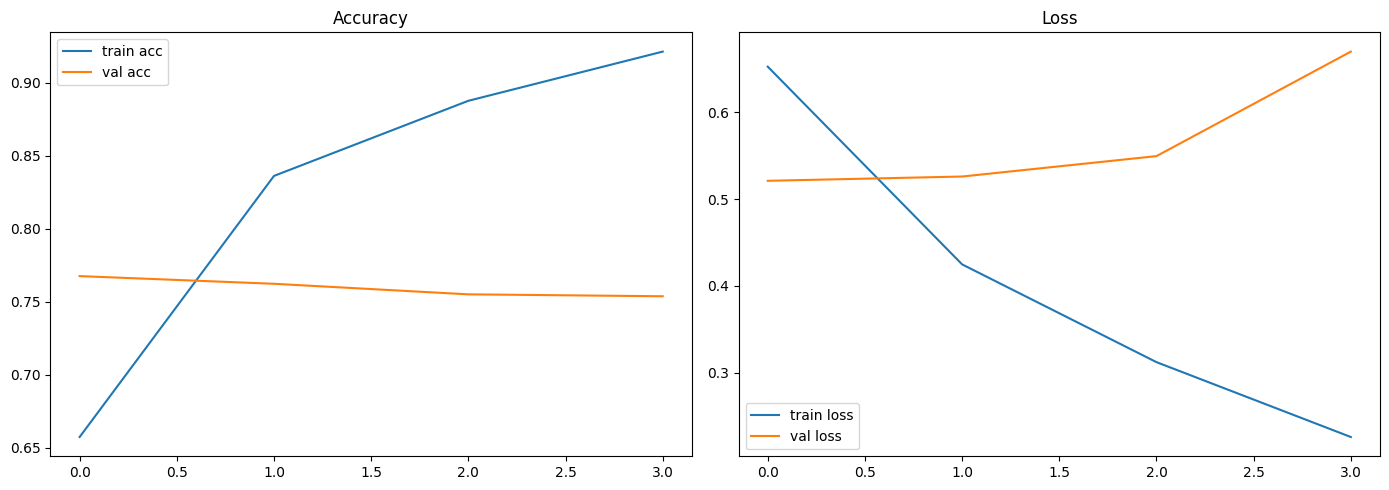

In [84]:
import tensorflow as tf
from tensorflow.keras.callbacks import ( EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.layers import SpatialDropout1D, GRU

np.random.seed(SEED)
tf.random.set_seed(SEED)

#Build and Train GRU RNN
inp = Input(shape=(MAXLEN,), dtype='int32')


x   = Embedding(
          input_dim=VOCAB_SIZE,
          output_dim=EMBED_DIM,
          input_length=MAXLEN
      )(inp)
#SpatialDropout1D helps regularize embeddings
x = SpatialDropout1D(0.3)(x)
#Bidirectional GRU with recurrent & input dropout
x = Bidirectional(GRU(64,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))(x)
x = Bidirectional(GRU( 32, dropout=0.2,recurrent_dropout=0.2))(x)
#Dense + heavy Dropout
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model_gru = Model(inputs=inp, outputs=out)

#compline with adamw optimizer 
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4
)

model_gru.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model_gru.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
]

# model training
history = model_gru.fit(
    X_train_txt, y_train,
    validation_data=(X_val_txt, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# VISUALIZE (side by side)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='train acc')
axs[0].plot(history.history['val_accuracy'], label='val acc')
axs[0].legend()
axs[0].set_title('Accuracy')

# Loss plot
axs[1].plot(history.history['loss'], label='train loss')
axs[1].plot(history.history['val_loss'], label='val loss')
axs[1].legend()
axs[1].set_title('Loss')

plt.tight_layout()
plt.show()



## 4. Final Conclusion

In our case LSTM RNN architecture gave better results than a GRU architecture.

## 5. Future Work 

- I this key is in data preprocessing. Cleaning and better tokenization techniques using GloVe can perform better results.

- we can use some more robust hyperparameter tuning for both models to see what bests work.

## 6. Kaggel Submission

In [99]:
# Load and clean the test data
test ['clean_text'] = test ['text'].astype(str).apply(clean_text)
X_test_seq  = tokenizer.texts_to_sequences(test['clean_text'])
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post', truncating='post')
X_test_meta = test[meta_cols].values

preds = model_lstm.predict(
    {'text_input': X_test_pad, 'meta_input': X_test_meta},
    batch_size=BATCH_SIZE
)

submission_lstm = pd.DataFrame({
    'id': test['id'],
    'target': (preds.flatten() > 0.5).astype(int)
})
submission_lstm.to_csv('submission_lstm.csv', index=False)
print("LSTM model submission file created successfully!")
print(submission_lstm.head())

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
LSTM model submission file created successfully!
   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1
